# 04_adaboost_model
In this notebook, we will use ADAboost to find the model with the best parameters for predictin Budget_Change_Ration and Schedule_Change_Ratio.

All possible combinations of model attributes are considered when searching for the best models.

Becasue ADABoost is a nonparametric model, we do not scale the data.  Initial attempts to imporove the results by scaling had no impact.

<a name='index'></a>

# Contents of this notebook


1. <a href=#cats>Consolidate Project Categories</a>


2. <a href=#subset>Subset and scale data for `X` and `y` frames</a>


3. <a href=#fit>**Fit boosted tree models using sklearn `AdaBoostRegressor` and `generate_model_dict()` function**</a>


4. <a href=#plot>**Plot predictions against true `y` values**</a>

    - <a href=#plot1>**Version 1:** using the generate model dictionary directly</a>
    
    - <a href=#plot2>**Version 2:** extracting predictions from 2 model dicts and plotting together</a>
    


5. <a href=#results>**Examine the effects of `max_depth` and number of iterations on our results**</a>


6. <a href=#findings>**Findings (WE CAN ACHIEVE A HIGHER $R^2$ WITH ADABOOST!!!)**</a>

In [56]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [2]:
file_path_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
file_path_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
    
if os.path.isfile(file_path_train) and os.path.isfile(file_path_test):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [3]:
data_train = pd.read_csv(file_path_train)
data_test = pd.read_csv(file_path_test)

In [4]:
# entries
print(f"Number of dataset records: Train:{len(data_train)}  Test:{len(data_test)}")


Number of dataset records: Train:134  Test:15


<a name='fit'></a>

# Fit boosted tree models using sklearn AdaBoostRegressor and `generate_model_dict()` function


<a href=#index>Index</a>

#### NOTE:

- After setting up supportin functions, all combinations of attributes are iterated over and respective models are then trained and scored.

In [5]:
def generate_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Generates adaboost staged scores in order to find ideal number of iterations
    
    :return: tuple of 2D np.arrays for adaboost staged scores at each iteration and
             each response variable, one array for training scores and one for test 
    """
    staged_scores_train = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_train.reset_index(drop=True),
                        y_train.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    staged_scores_test = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_test.reset_index(drop=True),
                        y_test.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    return staged_scores_train, staged_scores_test

def plot_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Plots the adaboost staged scores for each y variable's predictions and iteration
    
    """
    # generate staged_scores
    training_scores, test_scores = generate_adaboost_staged_scores(
        model_dict, X_train, X_test, y_train, y_test
    )
    
    max_depth = model_dict['model'][0].base_estimator.max_depth
    learning_rate = model_dict['model'][0].learning_rate
    y_vars = [var.replace('_', ' ') for var in model_dict['y_variables']]

    # create list of iteration numbers for plotting
    iteration_numbers = np.arange(model_dict['model'][0].n_estimators) + 1

    # plot figure
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.title(
        "Number of iterations' effect on the AdaBoost Regessor's\nperformance "\
        "with max depth {} and learning rate {}".format(
            max_depth,
            learning_rate,
        ),
        fontsize=18,
    )

    ax.plot(
        iteration_numbers, training_scores[:, 0],
        color='k', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, test_scores[:, 0],
        color='k', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, training_scores[:, 1],
        color='silver', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[1]))

    ax.plot(
        iteration_numbers, test_scores[:, 1],
        color='silver', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[1]))

    ax.tick_params(labelsize=12)
    ax.set_ylabel("$R^2$ score", fontsize=16)
    ax.set_xlabel("number of adaboost iterations", fontsize=16)
    ax.set_xticks(iteration_numbers)
    ax.grid(':', alpha=0.4)
    ax.legend(fontsize=12, edgecolor='k')

    plt.tight_layout()
    plt.show();

In [14]:
# Iterate over combinations of attributes available saving the trained models in each iteration

%%time



def flatten(T):
    if type(T) != tuple: return (T,)
    if len(T) == 0: return ()
    else: return flatten(T[0]) + flatten(T[1:])

model_descr = 'AdaBoost tree ensemble unscaled data'

# set parameters for AdaBoostRegressor model object
max_depths = [2, 3, 5, 7]
learning_rate = 0.05
estimators = [20,40,60]
random_state = 109

# calculate all combinations of modeling options of attribute and responses
model_dicts = []

nondescr_attrbutes = ['Category_Code', 'Budget_Start', 'Duration_Start', ('umap_attributes_2D_embed_1', 'umap_attributes_2D_embed_2')]
descr_attributes = [['umap_descr_2D_embed_1', 'umap_descr_2D_embed_2'],
                    ['ae_descr_embed_1', 'ae_descr_embed_2'],
                    ['pca_descr_embed_1', 'pca_descr_embed_2']]

responses = ['Budget_Change_Ratio', 'Schedule_Change_Ratio']


print("Using ADABoost REGRESSION models")
for n_estimators in tqdm(estimators, desc="n_estimators"):
    for max_depth in tqdm(max_depths, desc="max_depths", leave=False):
        for i in tqdm(range(1, len(nondescr_attrbutes)), desc="nondesc attributes", leave=False):
            alist = list(itertools.combinations(nondescr_attrbutes, i))
            alist = [flatten(a) for a in alist]
            
            for a in tqdm(alist, desc="nondesc attributes combinations", leave=False):
                a = list(a)

                model_dict = generate_model_dict(
                                                    AdaBoostRegressor,
                                                    model_descr,
                                                    data_train[a], data_test[a], data_train[responses], data_test[responses],
                                                    multioutput=False,
                                                    verbose=False,
                                                    predictions=True,
                                                    scores=True,
                                                    model_api='sklearn',
                                                    # these parameters below will be passed as *kwargs,
                                                    # which means they will feed directly to the model object
                                                    # when it is initialized
                                                    base_estimator=DecisionTreeRegressor(
                                                        max_depth=max_depth, random_state=random_state
                                                    ),
                                                    learning_rate = learning_rate,
                                                    n_estimators = n_estimators,
                                                    random_state=random_state
                                                )

                staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(model_dict, data_train[a], data_test[a], data_train[responses], data_test[responses])

                model_dict.update({ 'staged_scores_train': staged_scores_train, 
                                    'staged_scores_test':staged_scores_test,
                                    'max_depth': max_depth, 
                                    'learning_rate': learning_rate, 
                                    'n_estimators': n_estimators,
                                    'attributes': a,
                                    'responses': responses,
                                    'random_state': random_state})
                model_dicts.append(model_dict)

                for d_emb in tqdm(descr_attributes, desc="descriptions", leave=False):

                    model_dict = generate_model_dict(
                                                        AdaBoostRegressor,
                                                        model_descr,
                                                        data_train[a + d_emb], data_test[a + d_emb], data_train[responses], data_test[responses],
                                                        multioutput=False,
                                                        verbose=False,
                                                        predictions=True,
                                                        scores=True,
                                                        model_api='sklearn',
                                                        # these parameters below will be passed as *kwargs,
                                                        # which means they will feed directly to the model object
                                                        # when it is initialized
                                                        base_estimator=DecisionTreeRegressor(
                                                            max_depth=max_depth, random_state=random_state
                                                        ),
                                                        learning_rate = learning_rate,
                                                        n_estimators = n_estimators,
                                                        random_state=random_state
                                                    )

                    staged_scores_train, staged_scores_test = generate_adaboost_staged_scores(model_dict, data_train[a + d_emb], data_test[a + d_emb], data_train[responses], data_test[responses])

                    model_dict.update({ 'staged_scores_train': staged_scores_train, 'staged_scores_test':staged_scores_test,
                                        'max_depth': max_depth, 
                                        'learning_rate': learning_rate, 
                                        'n_estimators': n_estimators,
                                        'attributes': a + d_emb,
                                        'responses': responses,
                                        'random_state': random_state})
                    model_dicts.append(model_dict)


Using REGRESSION models



CPU times: user 3min 55s, sys: 2.35 s, total: 3min 58s
Wall time: 4min 2s


In [60]:
len(model_dicts)

672

In [15]:
# Create a dataframe from the model_dicts to allow filtering on the models created
descriptions = []
train_scores_bud = []
train_scores_sch = []
test_scores_bud = []
test_scores_sch = []
max_depths = []
staged_scores_train = []
staged_scores_test = []
lrs = []
n_estimators = []

for m in model_dicts:
    descriptions.append(m['description'])
    train_scores_bud.append(m['score']['train'][0])
    train_scores_sch.append(m['score']['train'][1])
    test_scores_bud.append(m['score']['test'][0])
    test_scores_sch.append(m['score']['test'][1])
    max_depths.append(m['max_depth'])
    lrs.append(m['learning_rate'])
    n_estimators.append(m['n_estimators'])
    staged_scores_train.append(m['staged_scores_train'])
    staged_scores_test.append(m['staged_scores_test'])
    
results = pd.DataFrame.from_dict({
                        'description': descriptions,
                        'train_score_bud': train_scores_bud,
                        'train_score_sch': train_scores_sch,
                        'test_score_bud': test_scores_bud,
                        'test_score_sch': test_scores_sch,
                        'max_depth': max_depths,
                        'lr': lrs,
                        'n_estimators': n_estimators,
                        'staged_scores_train': staged_scores_train,
                        'staged_scores_test': staged_scores_test
                        })

In [40]:
results.sort_values(by='test_score_sch', ascending=False).head(3)

,description,train_score_bud,train_score_sch,test_score_bud,test_score_sch,max_depth,lr,n_estimators,staged_scores_train,staged_scores_test
444,AdaBoost tree ensemble unscaled data,1.00,0.96,-0.07,0.70,7,0.05,40,"[[0.970832325694863, 0.7604005569140995], [0.9...","[[-0.032717426363226165, 0.4681959036145342], ..."
204,AdaBoost tree ensemble unscaled data,1.00,0.93,-0.15,0.69,7,0.05,20,"[[0.6753933092115462, 0.7651227626271309], [0....","[[-0.10821201757168764, 0.4652116494812605], [..."
332,AdaBoost tree ensemble unscaled data,0.99,0.73,0.14,0.69,3,0.05,40,"[[0.9646808181742339, 0.6400864763644332], [0....","[[0.31276919259203106, 0.500042088490582], [0...."


## Review the Impact of N_estiamtors and Max_depth

In [18]:
#we limit the outliers for display
results_no_outliers = results[(results.test_score_bud>-.4) & (results.test_score_sch>-.4)]

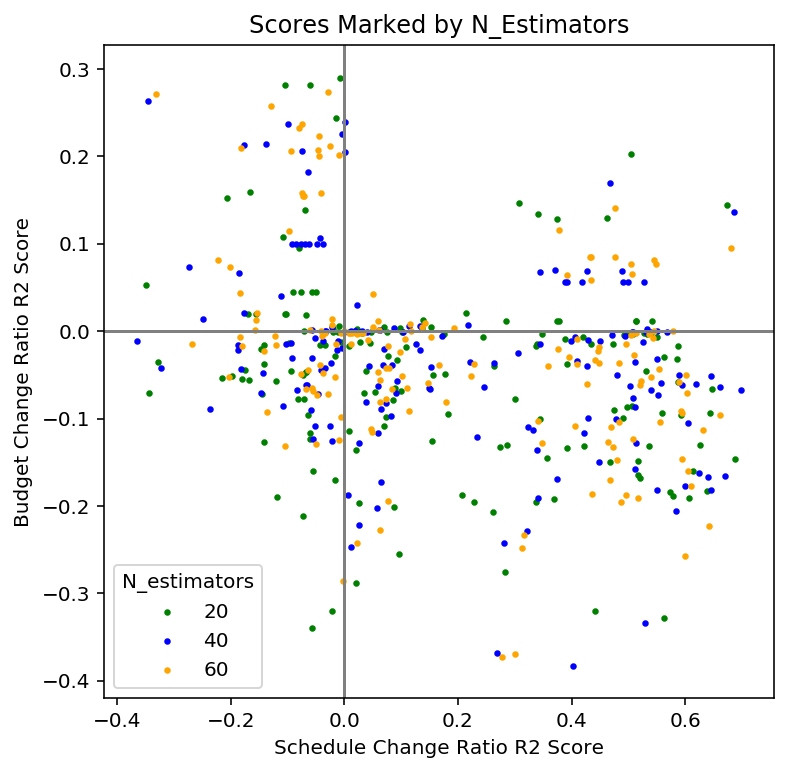

In [43]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, e in enumerate(estimators):
    sct_data = results_no_outliers[results_no_outliers.n_estimators==e]
    plt.scatter(sct_data.test_score_sch, sct_data.test_score_bud, c=colors[i], s=5, label=e)

plt.legend()
plt.legend(title="N_estimators")
plt.title("Scores Marked by N_Estimators")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');


### Here we want to see if there is any pattern in the n_estimators parameter.  We observe no trend that indicates any value performs consistently better than the others.

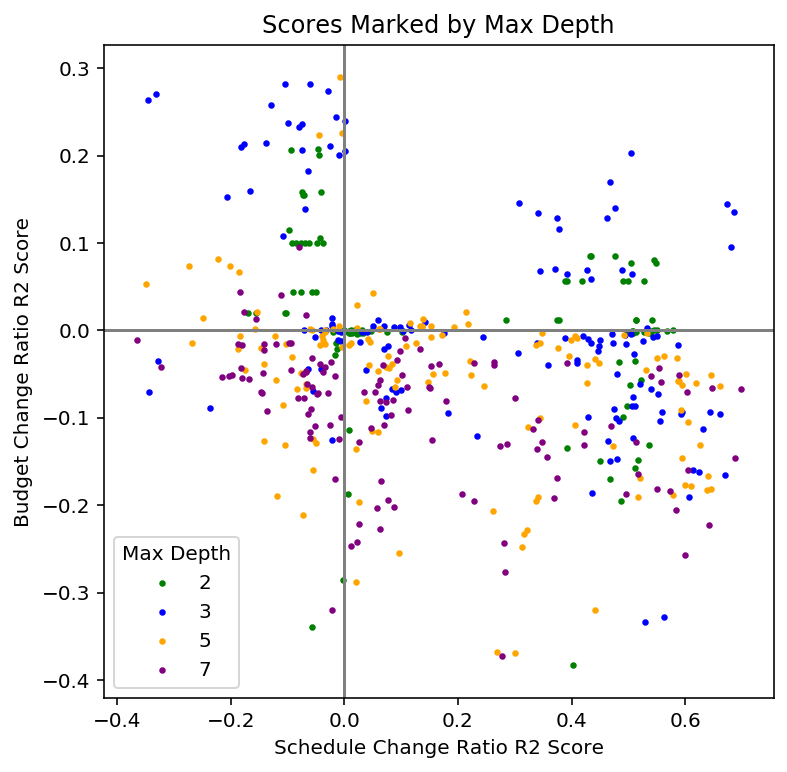

In [53]:
colors = ['g', 'b', 'orange', 'purple']
plt.figure(figsize=(6,6))

for i, m in enumerate(np.unique(max_depths)):
    sct_data = results_no_outliers[results_no_outliers.max_depth==m]
    plt.scatter(sct_data.test_score_sch, sct_data.test_score_bud, c=colors[i], s=5, label=m)

plt.legend(title="Max Depth")
plt.title("Scores Marked by Max Depth")
plt.axhline(c='gray')
plt.axvline(c='gray')
plt.xlabel('Schedule Change Ratio R2 Score')
plt.ylabel('Budget Change Ratio R2 Score');

### Here, we want to see if the maximum depth parameter has any consistent impact on the models.  We notice that the max depths of 3 perform consistently better with schedule change; however the best budget change model has a max depth of 5.   Since ADABoost learns 'fast' by also considering errors in training iterations, we can expext that lower numbers for max depth would product good results.  Predicting Budget values has been consistently more difficuly, so it makes sense that a larger max_depth is needed to find the optimal model for predicting the budget values.

## Best Scoring Budget Change Ratio Prediction Model

Best Budget Change Ratio Prediction Model
Train Score: 0.9942
Test Score: 0.2897


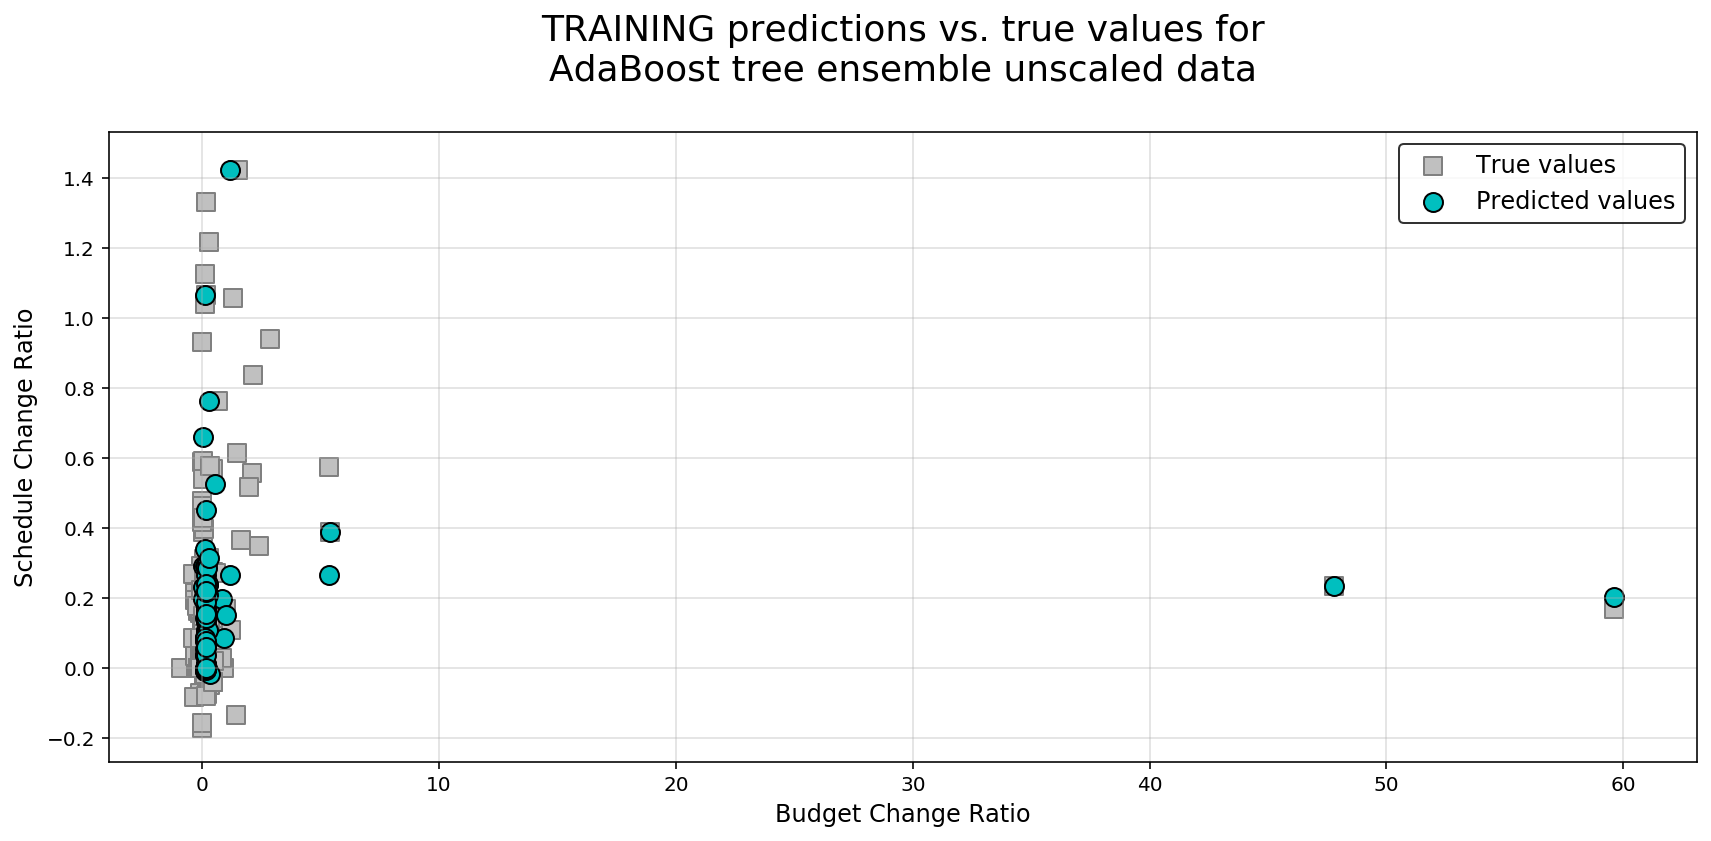

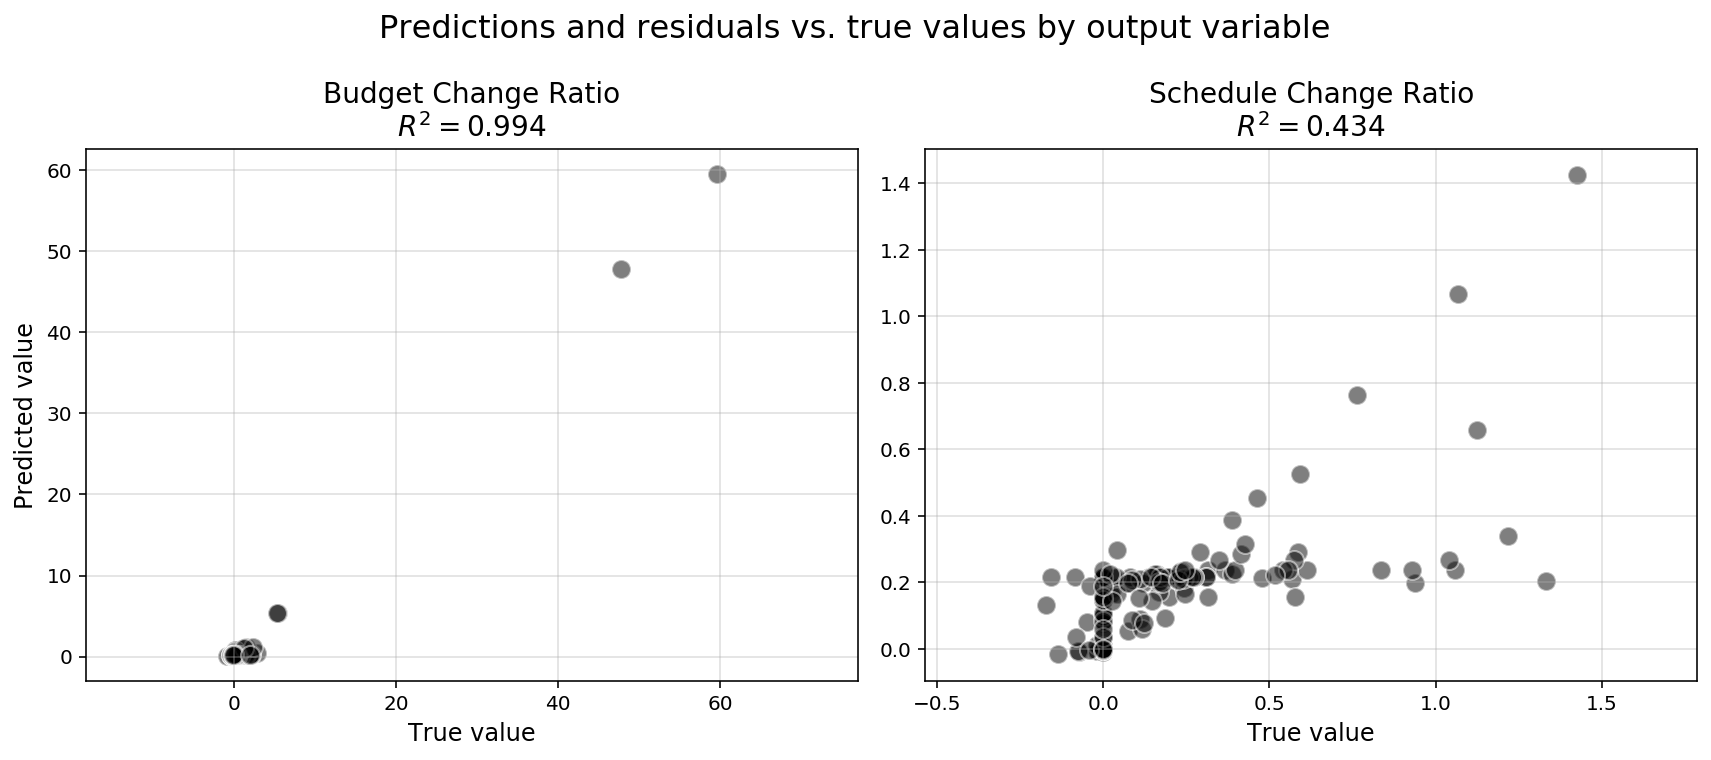

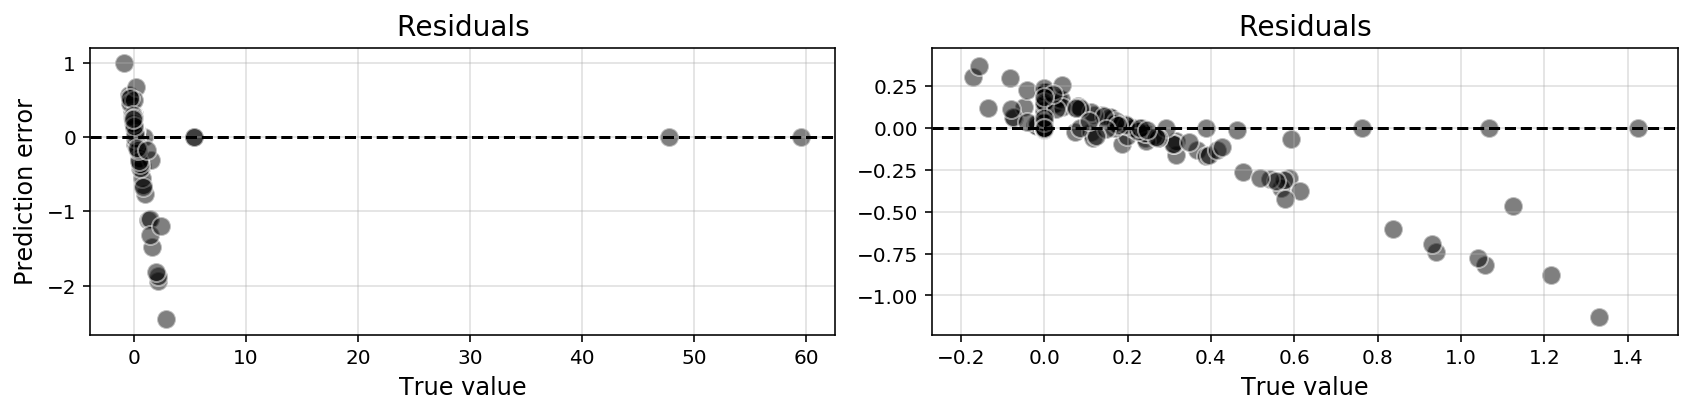

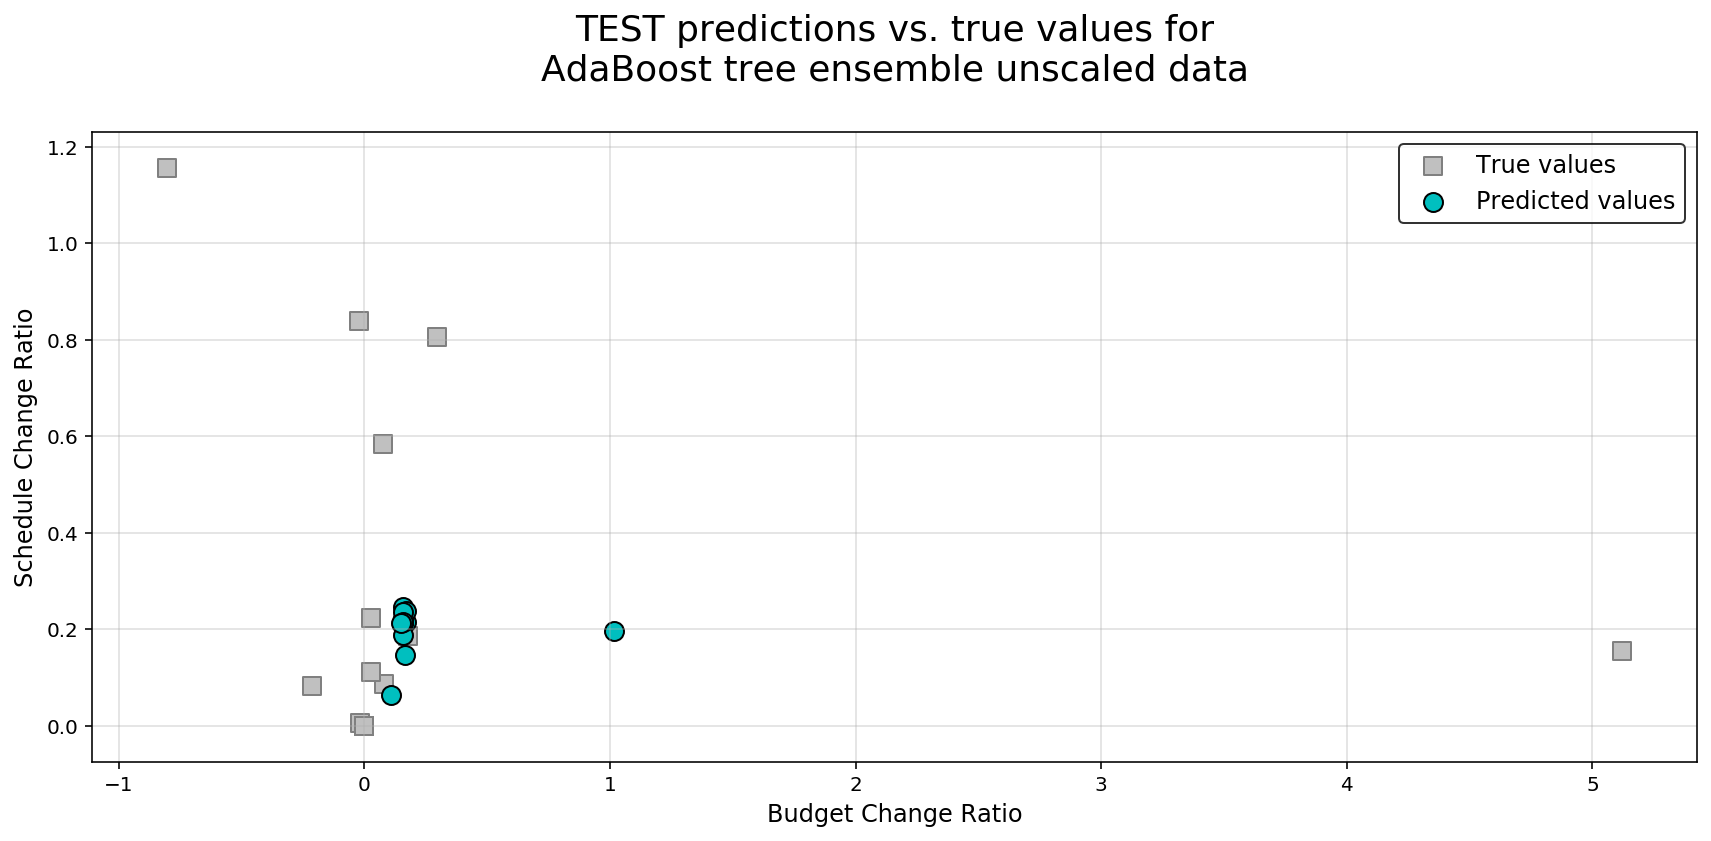

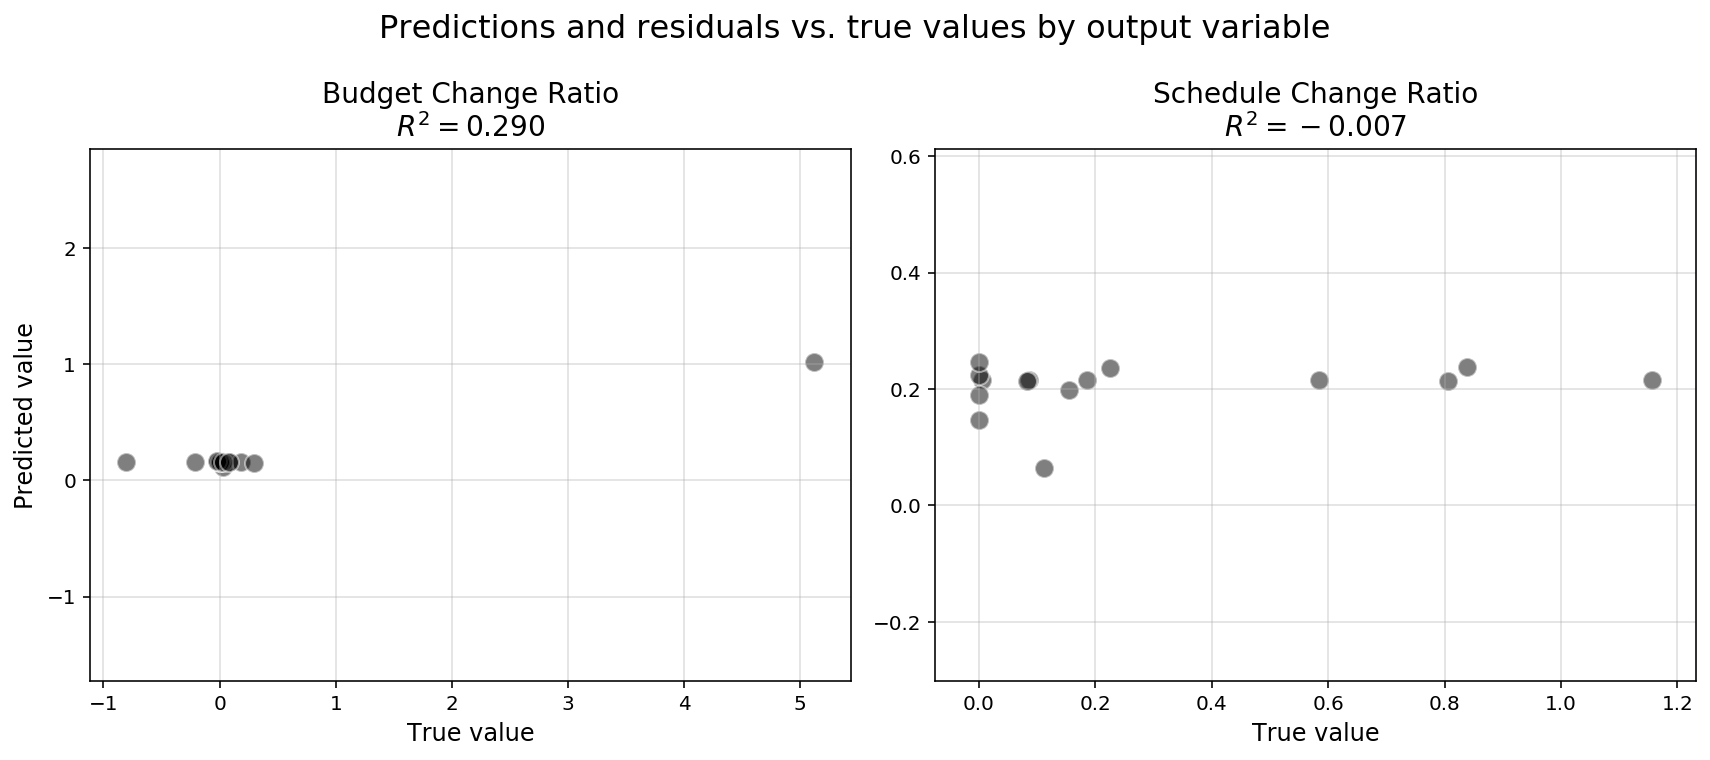

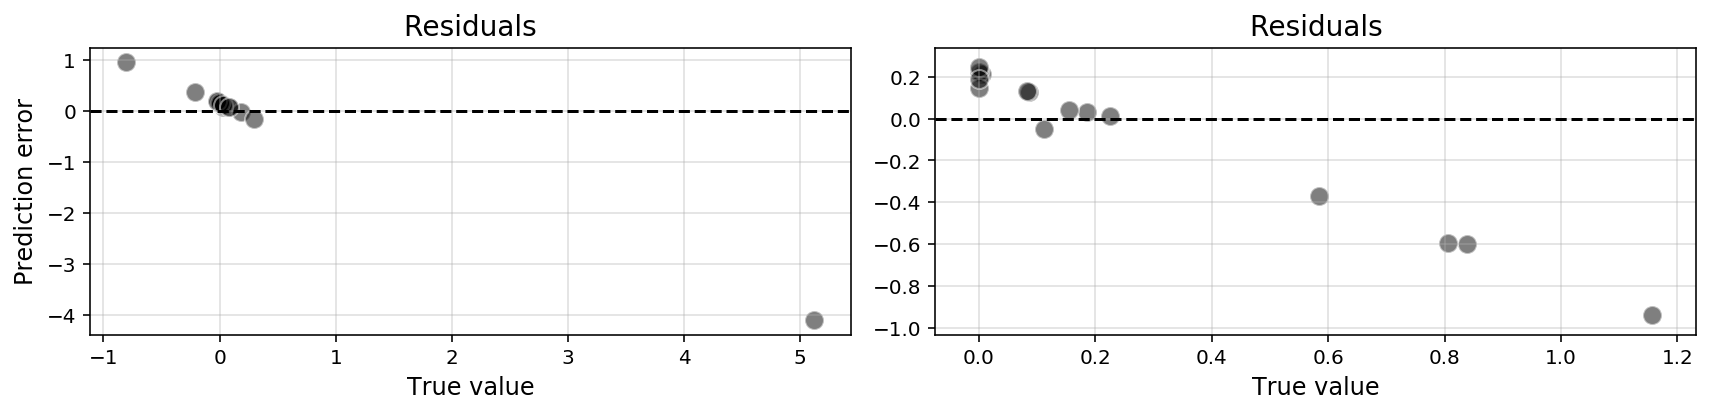

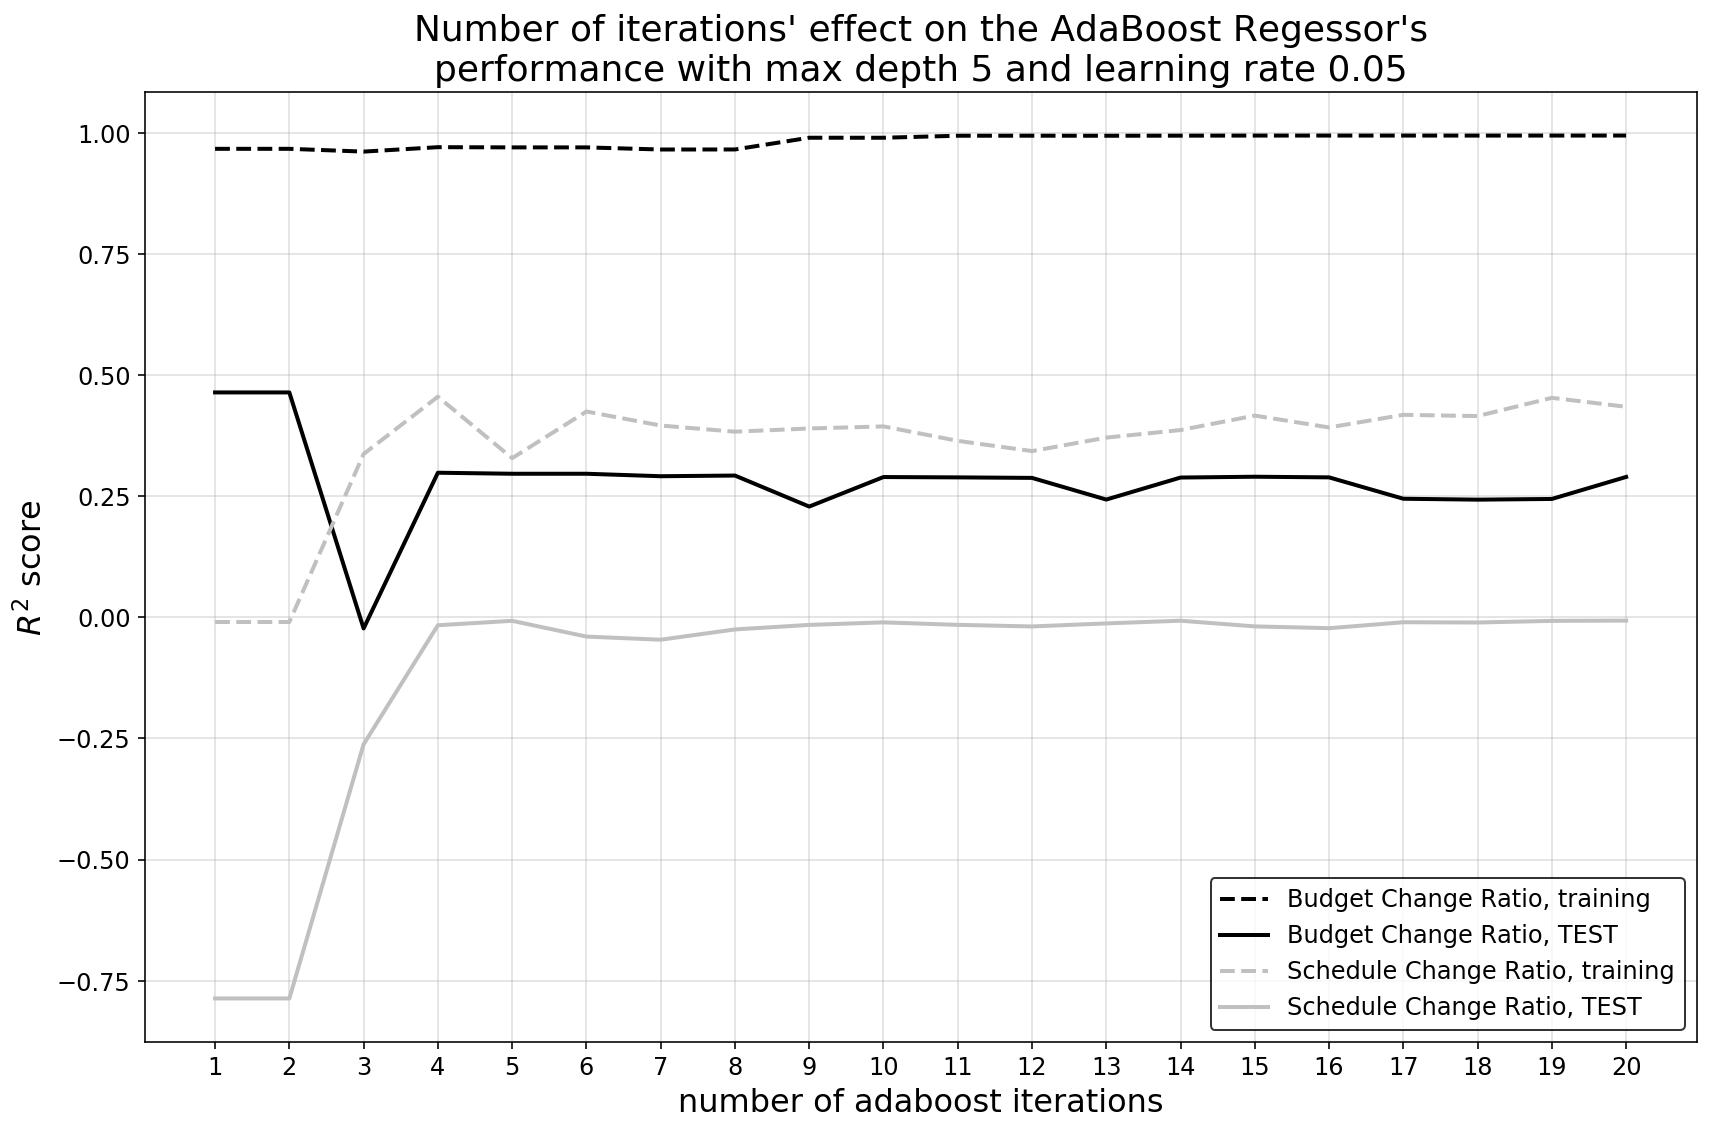

In [57]:
# best scoring model predicting schedule changes
idx = results.sort_values(by='test_score_bud', ascending=False).iloc[0].name
m = model_dicts[idx]
best_budget_model = m.copy()
print("Best Budget Change Ratio Prediction Model")
print(f"Train Score: {round(m['score']['train'][0],4)}")
print(f"Test Score: {round(m['score']['test'][0],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(m, data_train[m.get('attributes')], data_test[m.get('attributes')], data_train[m.get('responses')], data_test[m.get('responses')])

with open('../models/adaboost_regressor_budget_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best adabost-regressor model predicting budget_change_ratio',
                    'model': m['model'],
                    'attributes': m['attributes'],
                    'responses': m['responses']
                }, fp)

### Here, the final graphic is most interesting.  This model is optimized for predicting the budget change.  The best result is found after the first iteration indicating that we may be using far too many iterations in the training.  On the first iteration, the model is already overtrained.  It is possible that the limited data set is not complex enough for this Adaboost model.  Schedule change performs poorly here which is reasonable.  We picked a model that was optimized for budget change.  Showing the performance of both responses emphasizes the choice we made not to try to find a model that predicts both budget and schedule.

## Best Scoring Schedule Change Ratio Prediction Model

Best Schedule Change Ration Prediction Model
Train Score: 0.9607
Test Score: 0.6981


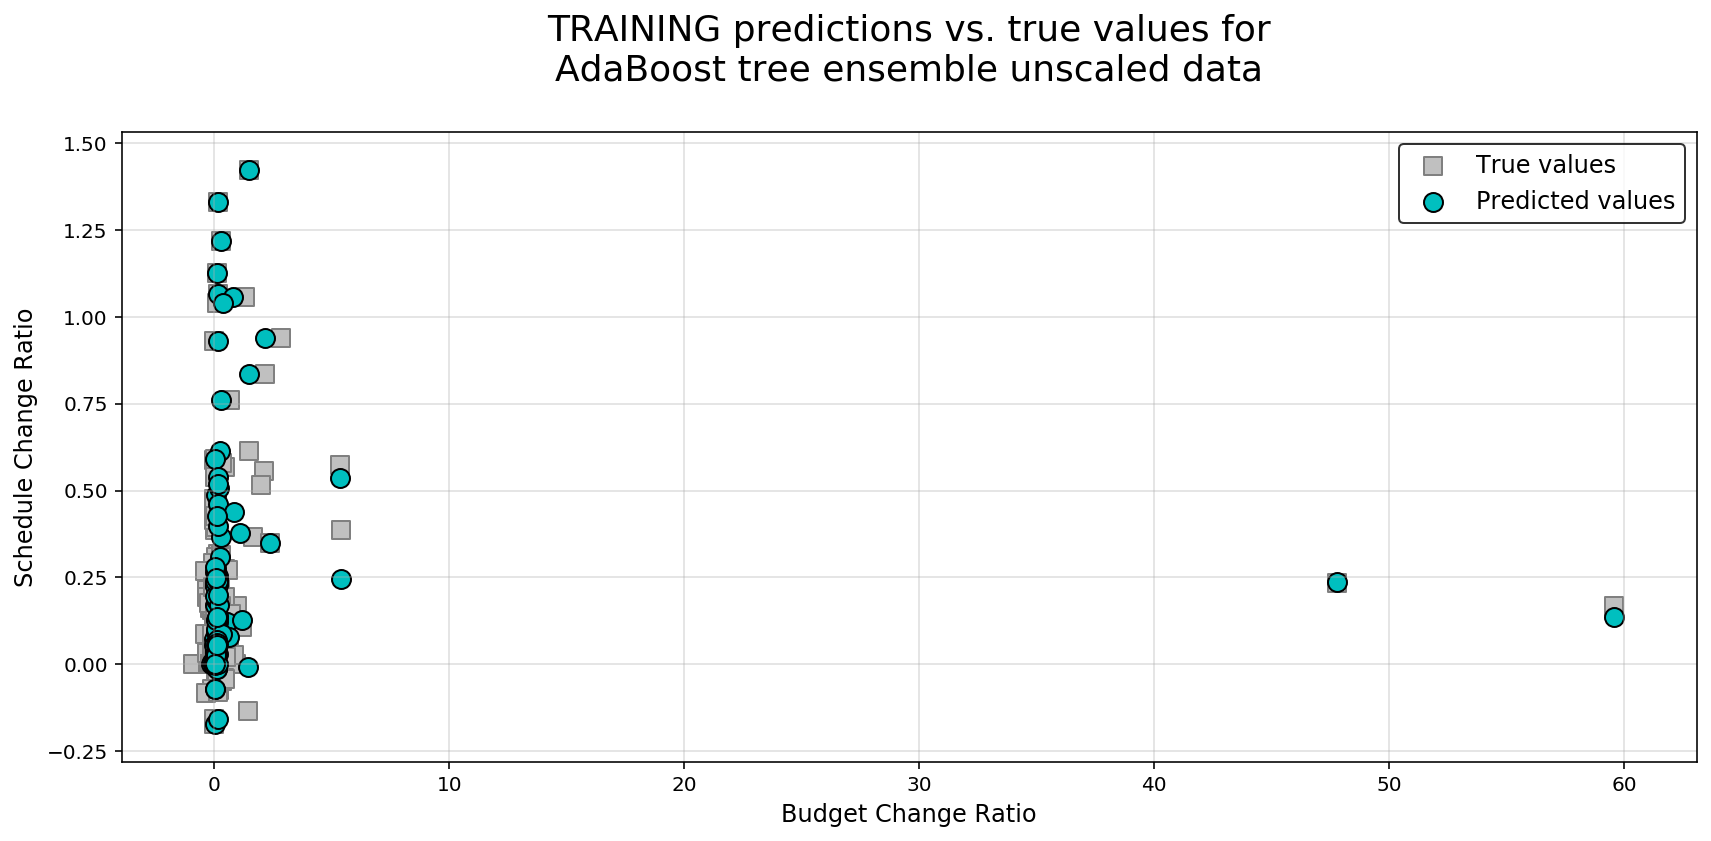

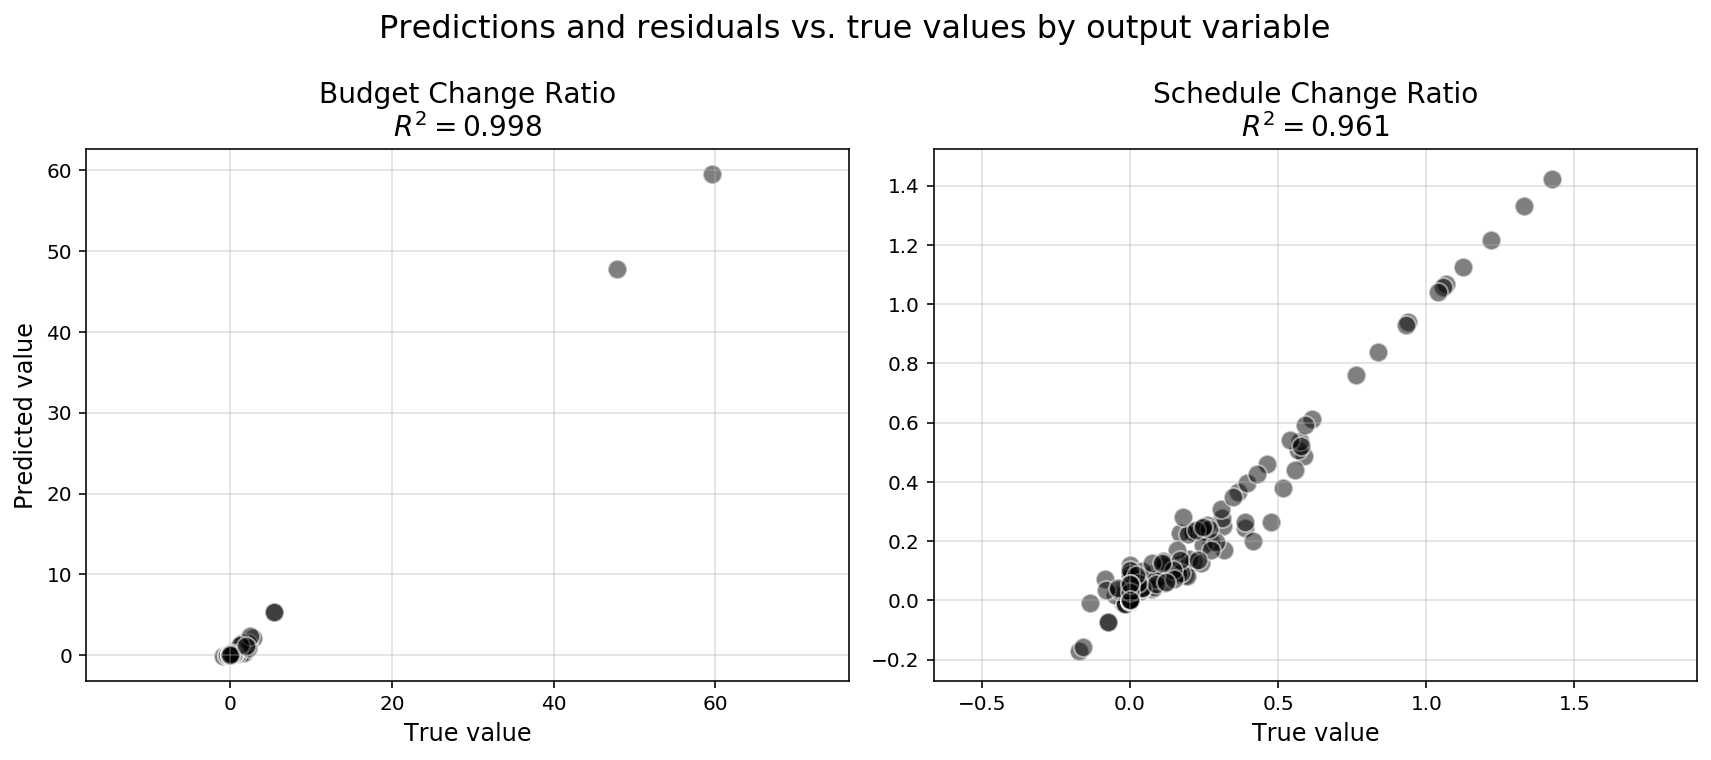

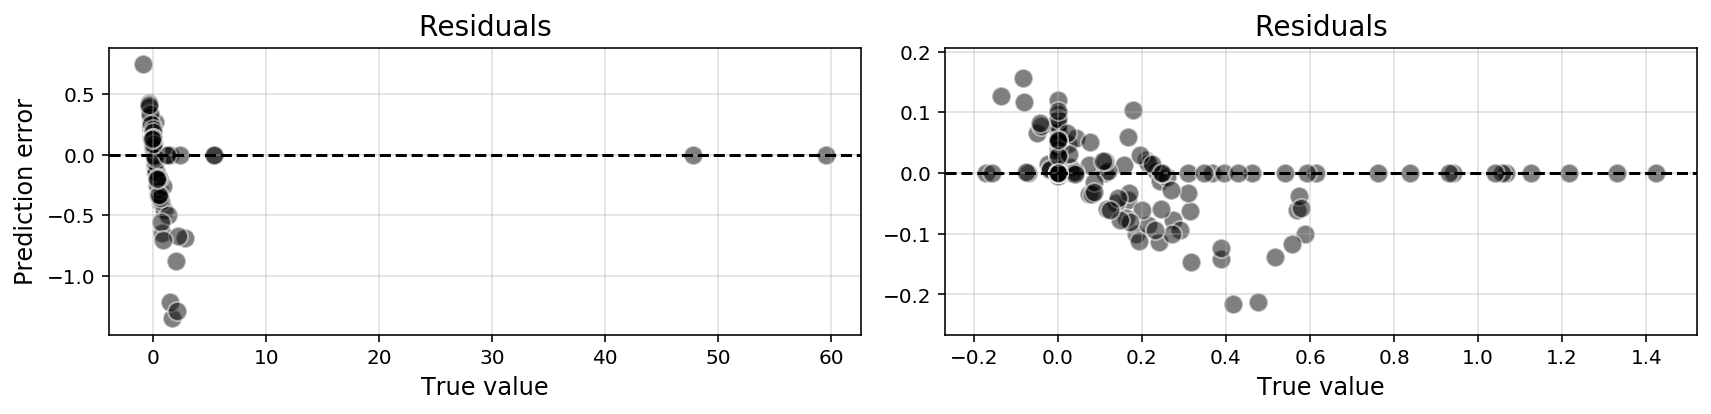

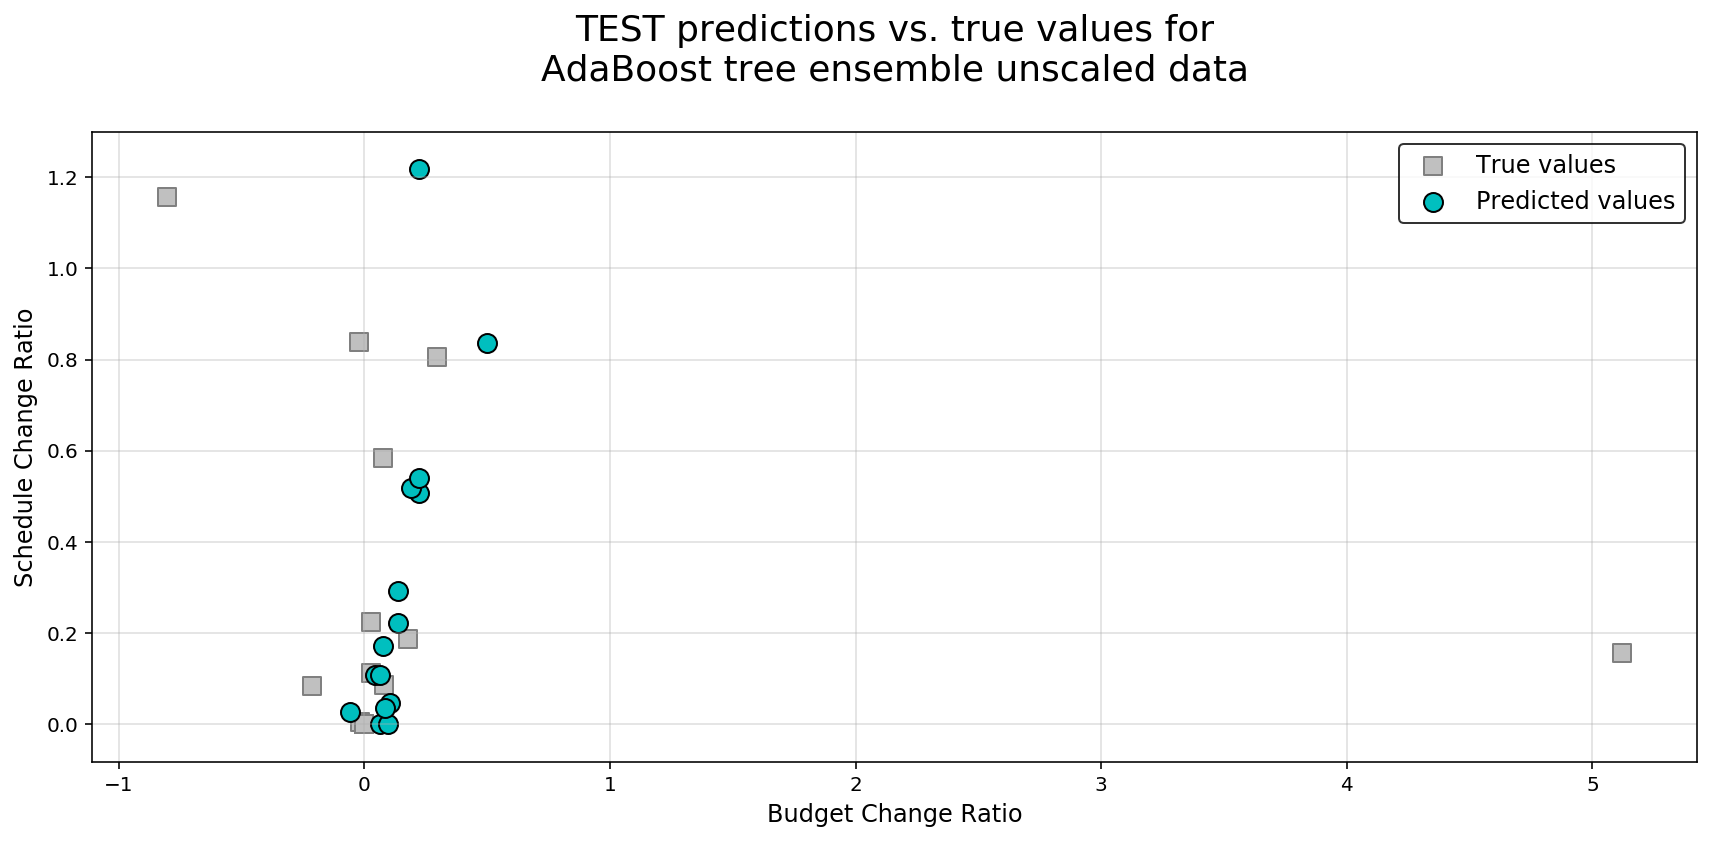

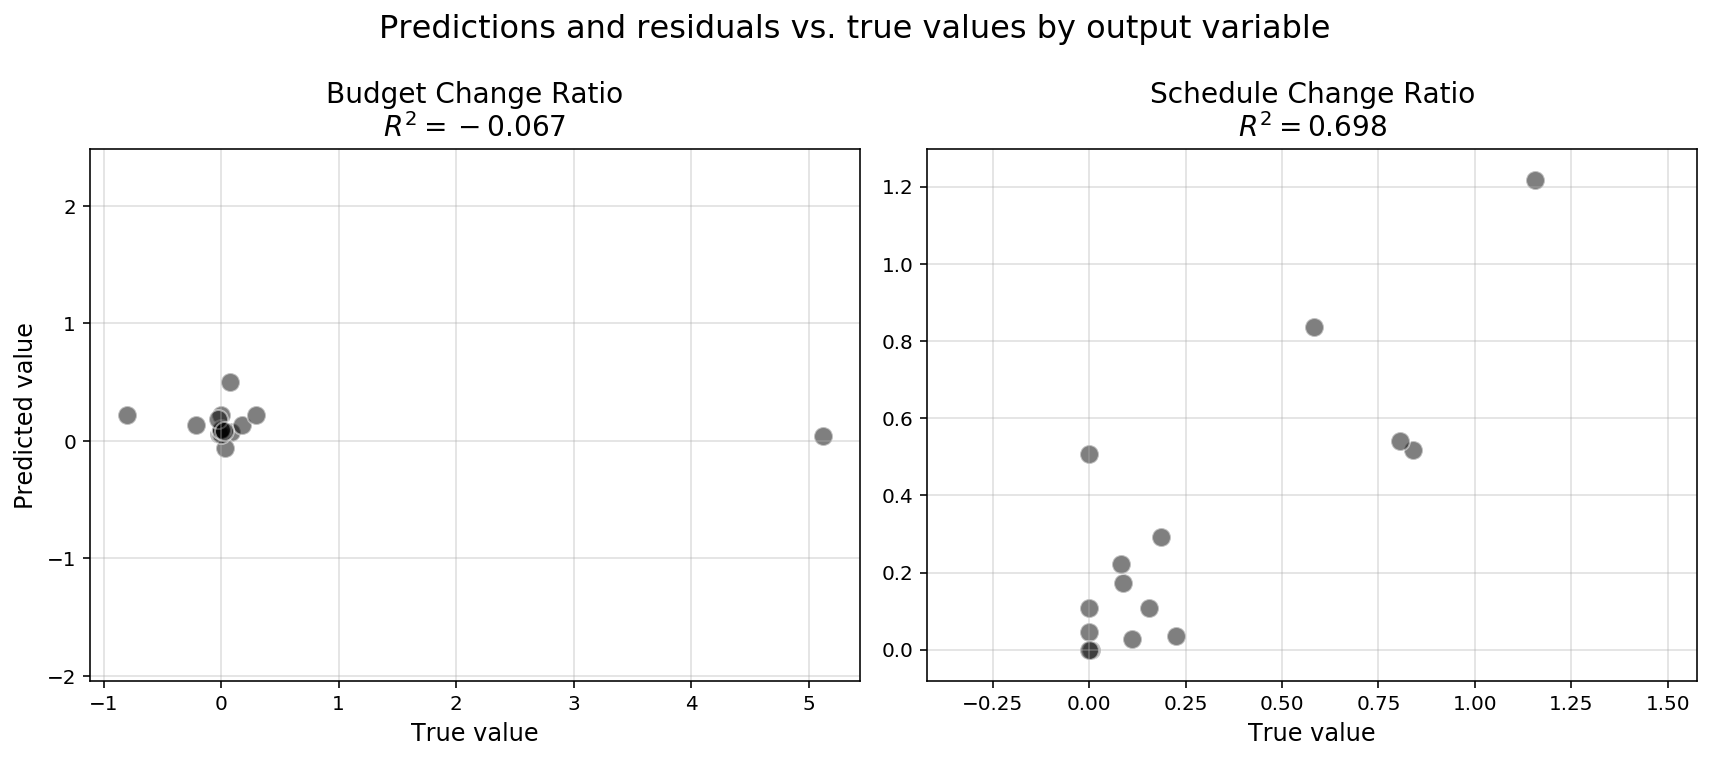

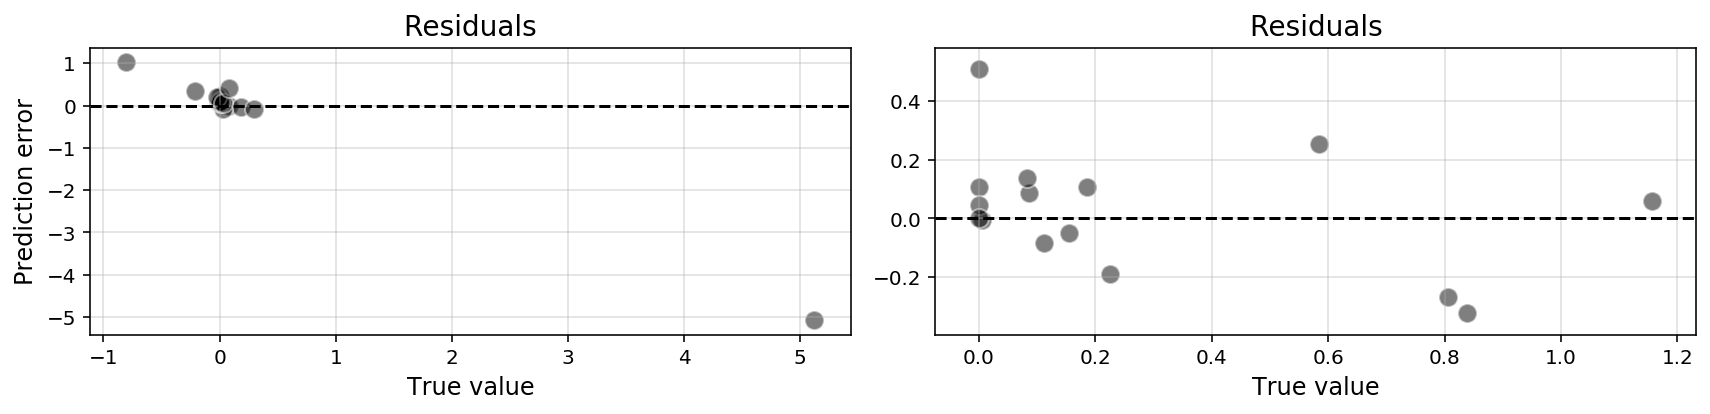

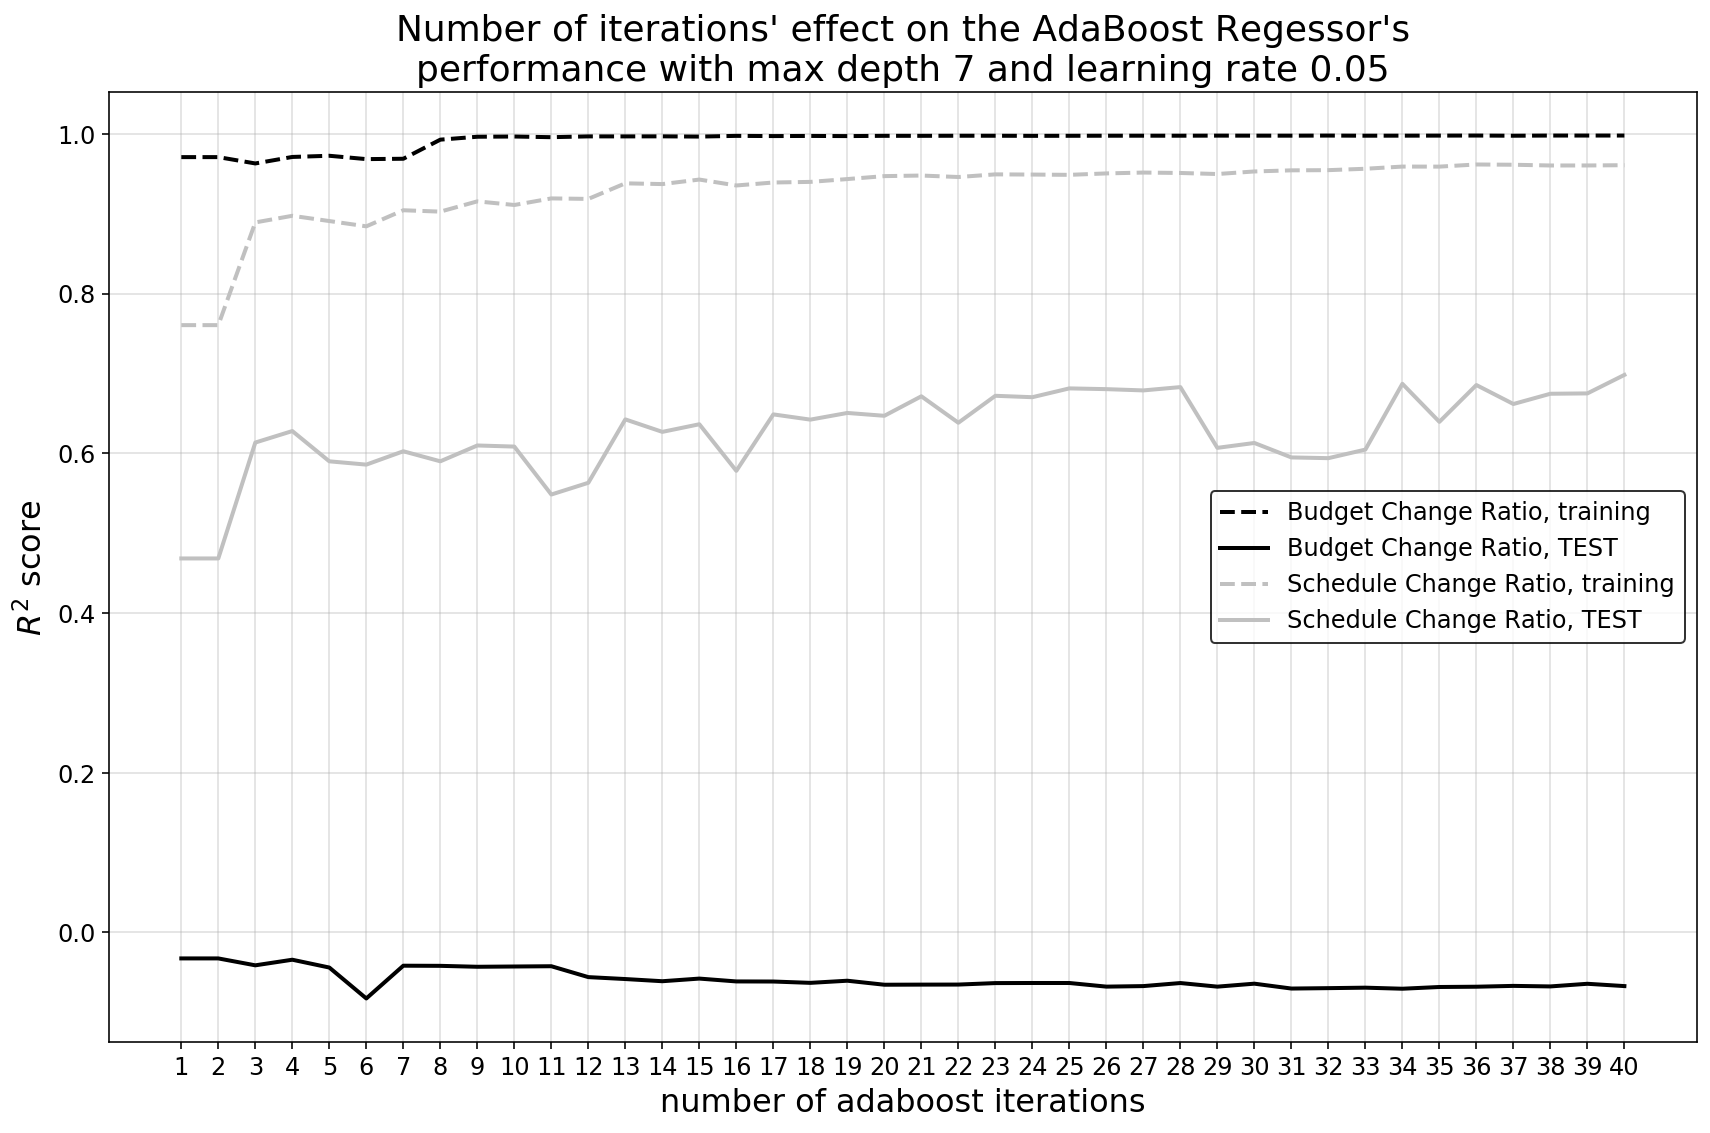

In [58]:
idx = results.sort_values(by='test_score_sch', ascending=False).iloc[0].name
m = model_dicts[idx]
best_schedule_model = m.copy()
print("Best Schedule Change Ration Prediction Model")
print(f"Train Score: {round(m['score']['train'][1],4)}")
print(f"Test Score: {round(m['score']['test'][1],4)}")
plot_true_pred(model_dict=m, dataset='train')
plot_true_pred(model_dict=m, dataset='test')
plot_adaboost_staged_scores(m, data_train[m.get('attributes')], data_test[m.get('attributes')], data_train[m.get('responses')], data_test[m.get('responses')])

with open('../models/adaboost_regressor_schedule_change_ratio.pkl', 'wb') as fp:
    pickle.dump({
                    'desc': 'best adabost-regressor model predicting schedule_change_ratio',
                    'model': m['model'],
                    'attributes': m['attributes'],
                    'responses': m['responses']
                }, fp)

### Again, the most complling chart is the last one.  This model was optimized for schedule change and we see a reasonably good performance that increases with more iterations.  The model which trains on 60 iterations was not chosen as optimal so we can safely assume that performance drops after 40 iterations.  Again, we note that the budget predictions perform poorly here as this model is not optimized for budget predictions.

In [30]:
y_pred_train = np.hstack(
    [
        best_schedule_model['predictions']['train'][:, 0].reshape(-1,1),
        best_budget_model['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        best_schedule_model['predictions']['test'][:, 0].reshape(-1,1),
        best_budget_model['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

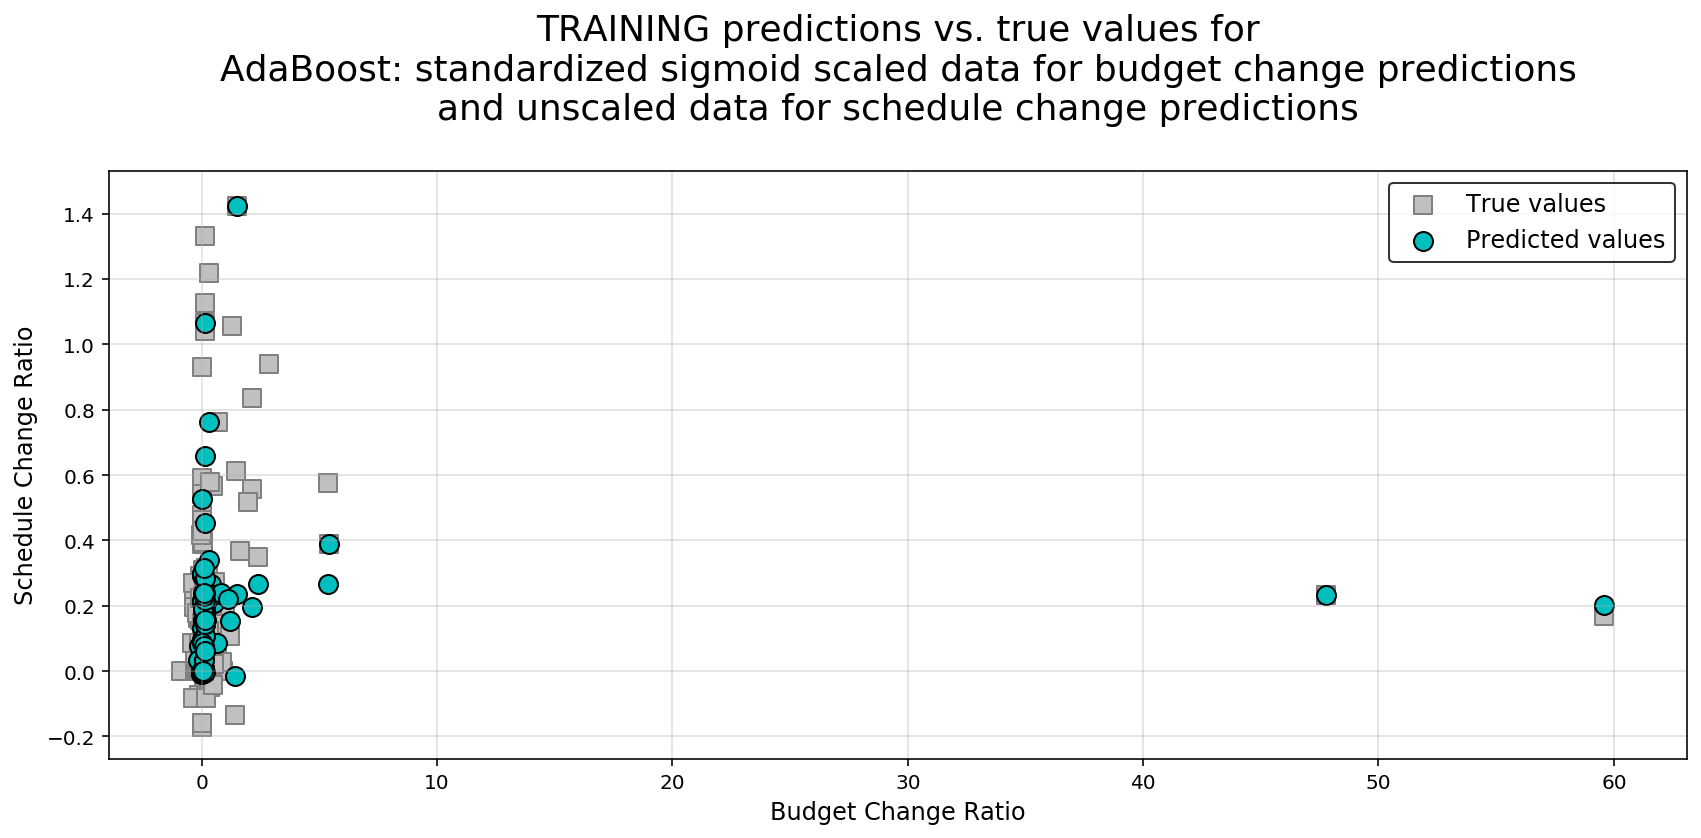

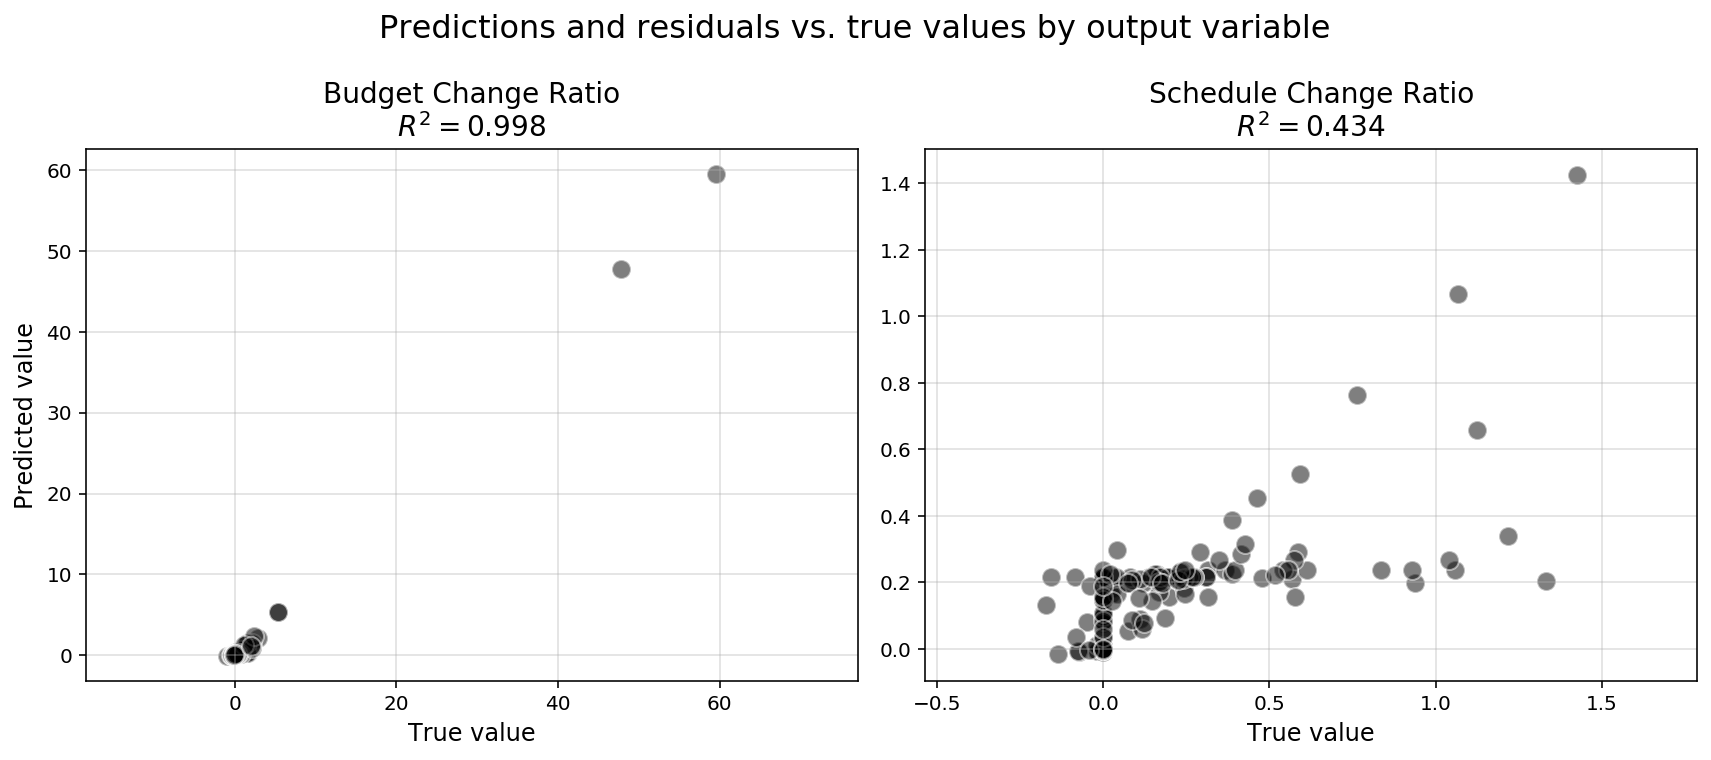

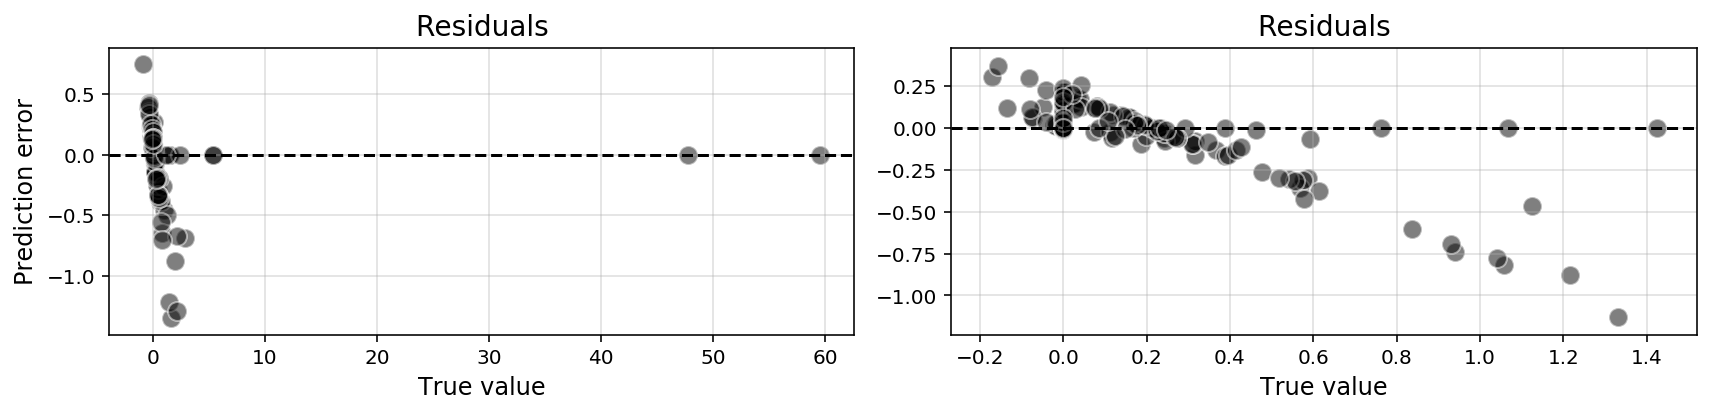

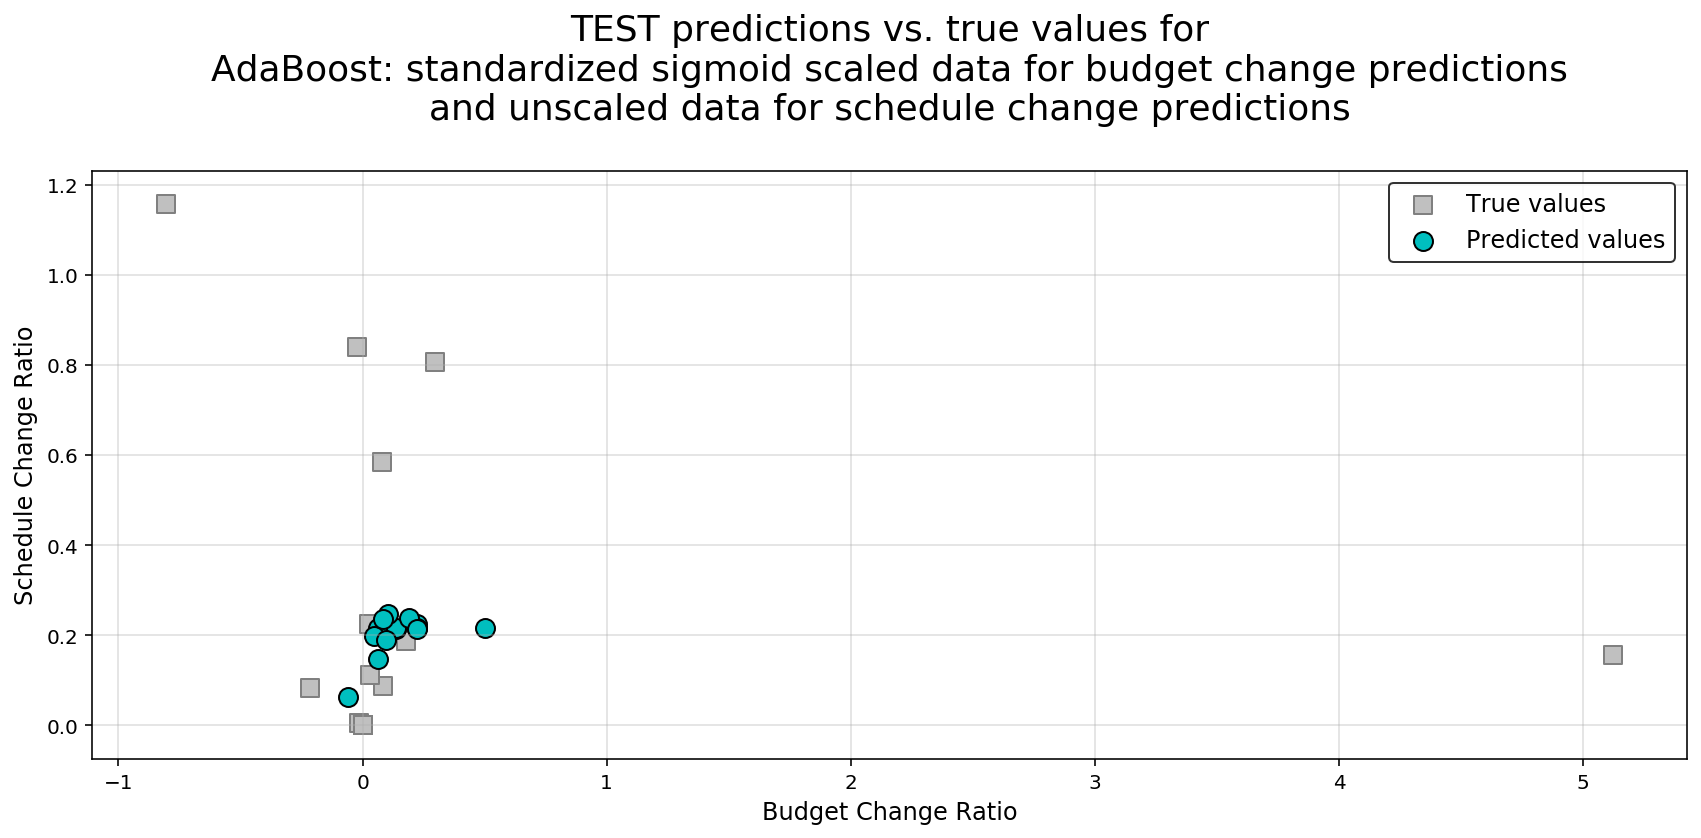

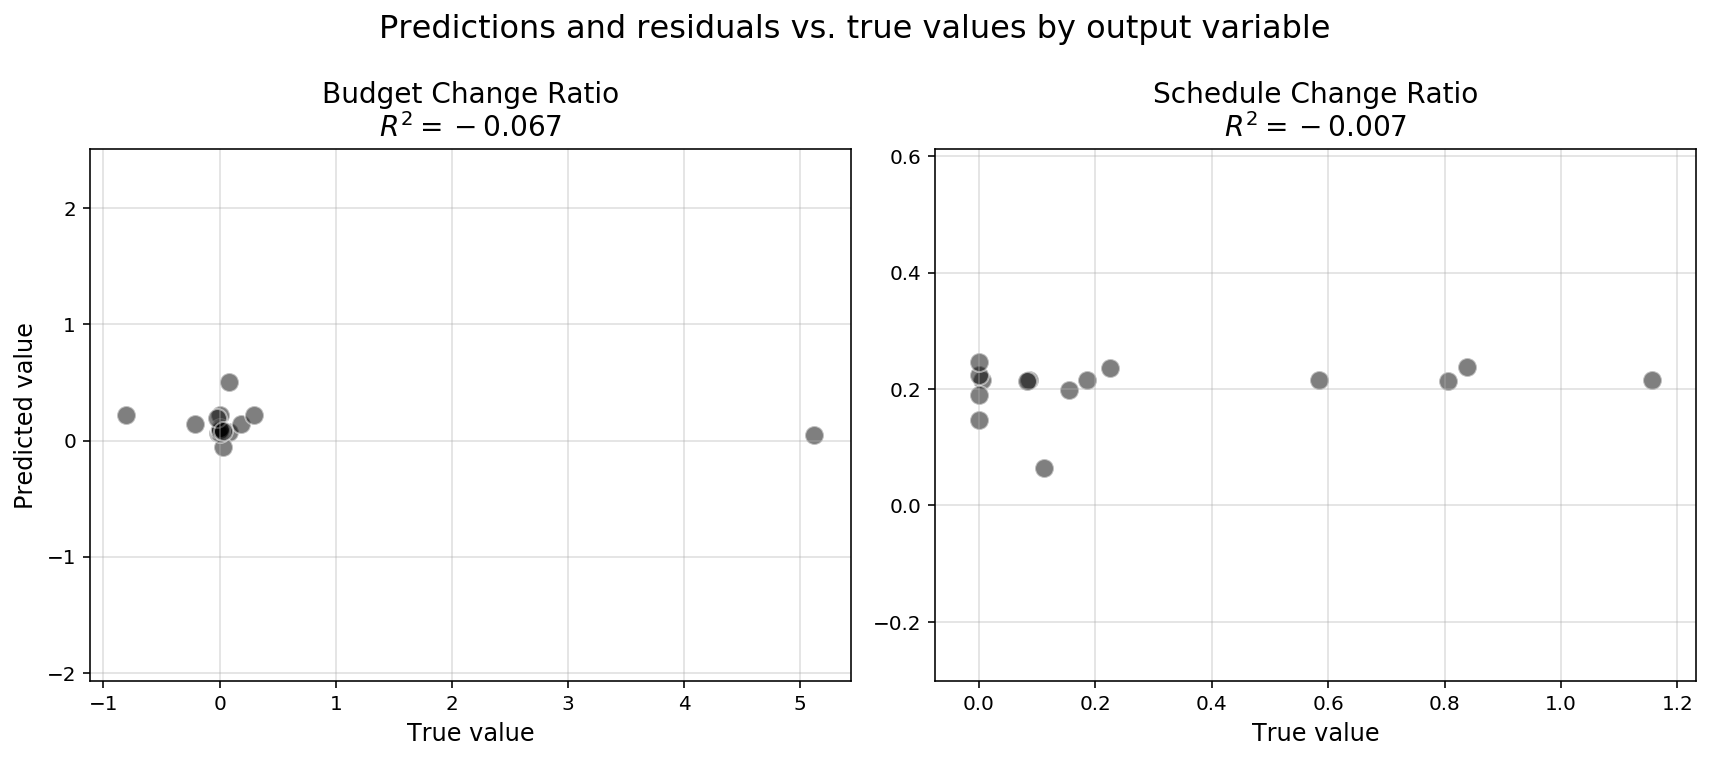

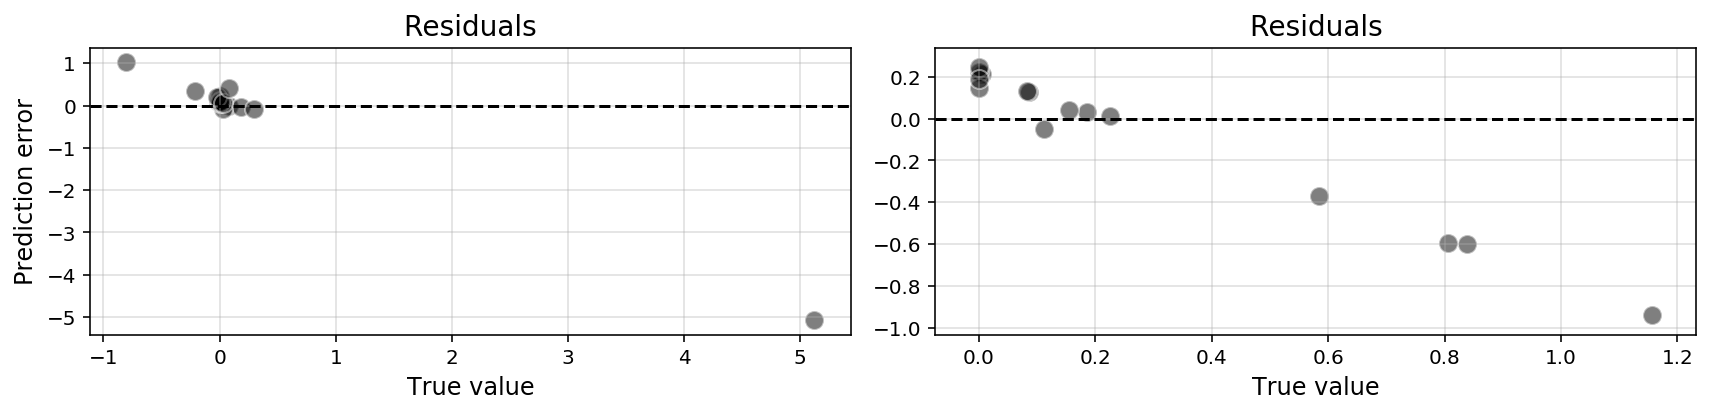

In [38]:
model_descr = 'AdaBoost: standardized sigmoid scaled data for budget change predictions\n'\
              'and unscaled data for schedule change predictions'
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=data_train[[y1_label.replace(' ','_'), y2_label.replace(' ','_')]], # y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=data_test[[y1_label.replace(' ','_'), y2_label.replace(' ','_')]], #y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

<a name='plot'></a>

# Plot predictions against true `y` values

<a href=#index>index</a>

<a name='plot1'></a>

## Version 1: Here I plot the results of one of the models by directly passing the one of the model dictionaries from above.

#### NOTE:

- I run the plotting function twice in the next cell. Once to show the 'train' results, once for the 'test' results

In [ ]:
plot_true_pred(model_dict=model_ada_sigscaled, dataset='train')
plot_true_pred(model_dict=model_ada_sigscaled, dataset='test')

<a name='plot2'></a>

## Version 2: Here I extract a set of predictions from each model dict and plot them together

### Example: if I want to present the `Budget_Change_Ratio` results from the sigmoid scaled data model in the same plot as the `Schedule_Change_Ratio` results from the unscaled data model, I convert the desired predictions from each respective model dictionary into new prediction matrix and pass those to the plotting function instead, as such...

#### NOTE:

- By using the `y_true`, `y_pred`, `y1_label`, `y_label`, and `model_descr` arguments **instead** of the `model_dict` argument, I can these new matrices directly. 

In [ ]:
y_pred_train = np.hstack(
    [
        model_ada_sigscaled['predictions']['train'][:, 0].reshape(-1,1),
        model_ada_unscaled['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_ada_sigscaled['predictions']['test'][:, 0].reshape(-1,1),
        model_ada_unscaled['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

In [ ]:
model_descr = 'AdaBoost: standardized sigmoid scaled data for budget change predictions\n'\
              'and unscaled data for schedule change predictions'
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

<a name='results'></a>

# Examine the effects of `max_depth` and number of iterations on our results

### Note, I can access the saved fitted models directly from the generated model dicts to create the results below

<a href=#index>index</a>

#### First I create a couple of functions to:

1. **Generate AdaBoost "staged scores" at each iteration of the AdaBoost fitted algorithm**
2. **Plot those staged scores for each `y` variable for both training and test**

In [ ]:
def generate_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Generates adaboost staged scores in order to find ideal number of iterations
    
    :return: tuple of 2D np.arrays for adaboost staged scores at each iteration and
             each response variable, one array for training scores and one for test 
    """
    staged_scores_train = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_train.reset_index(drop=True),
                        y_train.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    staged_scores_test = np.hstack(
        [
            np.array(
                list(
                    model.staged_score(
                        X_test.reset_index(drop=True),
                        y_test.reset_index(drop=True).iloc[:, i]
                    )
                )
            ).reshape(-1,1) for i, model in enumerate(model_dict['model'])
        ]
    )
    
    return staged_scores_train, staged_scores_test


def plot_adaboost_staged_scores(model_dict, X_train, X_test, y_train, y_test):
    """Plots the adaboost staged scores for each y variable's predictions and iteration
    
    """
    # generate staged_scores
    training_scores, test_scores = generate_adaboost_staged_scores(
        model_dict, X_train, X_test, y_train, y_test
    )
    
    max_depth = model_dict['model'][0].base_estimator.max_depth
    learning_rate = model_dict['model'][0].learning_rate
    y_vars = [var.replace('_', ' ') for var in model_dict['y_variables']]

    # create list of iteration numbers for plotting
    iteration_numbers = np.arange(model_dict['model'][0].n_estimators) + 1

    # plot figure
    fig, ax = plt.subplots(figsize=(12, 8))

    plt.title(
        "Number of iterations' effect on the AdaBoost Regessor's\nperformance "\
        "with max depth {} and learning rate {}".format(
            max_depth,
            learning_rate,
        ),
        fontsize=18,
    )

    ax.plot(
        iteration_numbers, training_scores[:, 0],
        color='k', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, test_scores[:, 0],
        color='k', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[0]))

    ax.plot(
        iteration_numbers, training_scores[:, 1],
        color='silver', linestyle='--', linewidth=2,
        label='{}, training'.format(y_vars[1]))

    ax.plot(
        iteration_numbers, test_scores[:, 1],
        color='silver', linestyle='-', linewidth=2,
        label='{}, TEST'.format(y_vars[1]))

    ax.tick_params(labelsize=12)
    ax.set_ylabel("$R^2$ score", fontsize=16)
    ax.set_xlabel("number of adaboost iterations", fontsize=16)
    ax.set_xticks(iteration_numbers)
    ax.grid(':', alpha=0.4)
    ax.legend(fontsize=12, edgecolor='k')

    plt.tight_layout()
    plt.show();

### Next I generate a couple of new `AdaBoostRegressor` model dictionaries, each with a different `max_depth`, both using the unscaled data

In [ ]:
model_descr = 'AdaBoost tree ensemble unscaled data with max depth of 3'

# set parameters for AdaBoostRegressor model object
max_depth = 3
learning_rate = 0.05
n_estimators = 40
random_state = 109


model_ada_unscaled_3 = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled_3)

model_descr = 'AdaBoost tree ensemble unscaled data with max depth of 5'

max_depth = 5

model_ada_unscaled_5 = generate_model_dict(
    AdaBoostRegressor,
    model_descr,
    X_train[features], X_test[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    # these parameters below will be passed as *kwargs,
    # which means they will feed directly to the model object
    # when it is initialized
    base_estimator=DecisionTreeRegressor(
        max_depth=max_depth, random_state=random_state
    ),
    learning_rate = learning_rate,
    n_estimators = n_estimators,
    random_state=random_state
)

print_model_results(model_ada_unscaled_5)


### Lastly, I plot the staged scores from each model to inspect the effect of `max_depth` and `n_estimators` (i.e number of iterations) on our `AdaBoostRegressor` model

In [ ]:
plot_adaboost_staged_scores(model_ada_unscaled_3, X_train, X_test, y_train, y_test)
plot_adaboost_staged_scores(model_ada_unscaled_5, X_train, X_test, y_train, y_test)

<a name='findings'></a>


# Findings:

<a href=#index>index</a>

Based on these results, it looks like increasing `max_depth` of our AdaBoost model's underlying `DecisionTreeRegressor` from 3 to 5 may possibly increase the predictive accuracy of our model for both `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions. However, the increased `max_depth` does look a little bit more unstable.

Also, it appears that different numbers of iterations (i.e. `n_estimators` parameters) for both sets of predictions will gain us improvements in $R^2$ scores for `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions.

 - `n_estimators = 2` for the `Budget_Change_Ratio` model if `max_depth = 5` or `max_depth = 3` 
 - `n_estimators = 5` for the `Schedule_Change_Ratio` model if `max_depth = 5` or `max_depth = 3`
 
**However, I think we'd want to conduct a true cross-validated grid search to arrive at these conclusions using only our training data with cross-validation to pick both our best `max_depth` and `n_estimators` parameters. Not by looking directly at our training results as I have done above, as I am sure a different train/test split will provide very different results.**

**If we are able to replicate these results using cross-validation, it means we can potentially achieve $R^2$ scores grater than 0.50 for both our `Budget_Change_Ratio` AND `Schedule_Change_Ratio` TEST predictions using only `Budget_Start`, `Duration_Start`, and `Category` as our predictors.**